In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE = "/content/drive/MyDrive/CarDD1"
RAW_IMG_DIR = "/content/drive/MyDrive/val2017/val2017"
RAW_COCO_JSON = "/content/instances_val2017.json"  # your COCO JSON file


IMG_TRAIN = f"{BASE}/images/train"
IMG_VAL   = f"{BASE}/images/val"
LBL_TRAIN = f"{BASE}/labels/train"
LBL_VAL   = f"{BASE}/labels/val"
RUNS_DIR  = f"{BASE}/runs"

for d in [IMG_TRAIN, IMG_VAL, LBL_TRAIN, LBL_VAL, RUNS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Drive mounted & folders ready.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted & folders ready.


In [ ]:
import json
from tqdm import tqdm
import os


NAMES = ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']
name_to_idx = {n: i for i, n in enumerate(NAMES)}


with open(RAW_COCO_JSON, 'r') as f:
    data = json.load(f)

image_map = {img['id']: img for img in data.get('images', [])}
cat_by_id = {c['id']: c.get('name', '').strip().lower() for c in data.get('categories', [])}


TMP_LABELS = f"{BASE}/labels/_all"
os.makedirs(TMP_LABELS, exist_ok=True)


per_image_lines = {}
for ann in tqdm(data.get('annotations', []), desc="Converting COCO → YOLO"):
    img = image_map.get(ann['image_id'])
    if not img:
        continue

    w, h = img['width'], img['height']
    x, y, bw, bh = ann['bbox']
    x_c, y_c = (x + bw/2)/w, (y + bh/2)/h
    bw, bh = bw/w, bh/h

    cat_name = cat_by_id.get(ann['category_id'], '').lower()
    if cat_name not in name_to_idx:
        continue
    cls = name_to_idx[cat_name]

    base = os.path.splitext(os.path.basename(img['file_name']))[0]
    per_image_lines.setdefault(base, []).append(f"{cls} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")


for base, lines in per_image_lines.items():
    with open(os.path.join(TMP_LABELS, base + ".txt"), "w") as f:
        f.write("\n".join(lines) + "\n")

print(f"Converted labels saved in {TMP_LABELS}")


Converting COCO → YOLO: 100%|██████████| 1744/1744 [00:00<00:00, 154442.63it/s]


Converted labels saved in /content/drive/MyDrive/CarDD1/labels/_all


In [ ]:
import shutil, random
random.seed(42)

def find_img(fname_base):
    for ext in (".jpg", ".jpeg", ".png"):
        p = os.path.join(RAW_IMG_DIR, fname_base + ext)
        if os.path.exists(p):
            return p
    return None


train_candidates = []
all_label_bases = set(os.path.splitext(f)[0] for f in os.listdir(TMP_LABELS))
for base in all_label_bases:
    img_path = find_img(base)
    if img_path:
        shutil.copy2(img_path, os.path.join(IMG_TRAIN, os.path.basename(img_path)))
        shutil.copy2(os.path.join(TMP_LABELS, base + ".txt"), os.path.join(LBL_TRAIN, base + ".txt"))
        train_candidates.append(os.path.basename(img_path))

# Split to val
random.shuffle(train_candidates)
val_count = max(1, int(0.2 * len(train_candidates)))
val_imgs = set(train_candidates[:val_count])

for img_file in val_imgs:
    base = os.path.splitext(img_file)[0]
    shutil.move(os.path.join(IMG_TRAIN, img_file), os.path.join(IMG_VAL, img_file))
    shutil.move(os.path.join(LBL_TRAIN, base + ".txt"), os.path.join(LBL_VAL, base + ".txt"))

# Cleanup temp labels
shutil.rmtree(TMP_LABELS, ignore_errors=True)

print(f"Train: {len(os.listdir(IMG_TRAIN))} images")
print(f"Val:   {len(os.listdir(IMG_VAL))} images")


Train: 648 images
Val:   162 images


In [ ]:
yaml_path = f"{BASE}/cardd.yaml"
yaml_content = f"""
train: {BASE}/images/train
val: {BASE}/images/val

nc: {len(NAMES)}
names: {NAMES}
""".strip()

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"YAML saved to {yaml_path}")


YAML saved to /content/drive/MyDrive/CarDD1/cardd.yaml


In [ ]:
!pip install -q ultralytics
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    project=RUNS_DIR,
    name="yolov8n_cardd",
    save_period=5,
    pretrained=True
)

print("Training complete.")
print(f"Best weights: {RUNS_DIR}/detect/yolov8n_cardd/weights/best.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/CarDD1/cardd.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_cardd, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           


  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192,

train: Scanning /content/drive/MyDrive/CarDD1/labels/train... 648 images, 0 backgrounds, 0 corrupt: 100%|██████████| 648/648 [00:11<00:00, 56.70it/s]


train: New cache created: /content/drive/MyDrive/CarDD1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ val: Slow image access detected (ping: 17.4±35.0 ms, read: 125.5±109.9 MB/s, size: 766.7 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/CarDD1/labels/val... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:01<00:00, 118.89it/s]


val: New cache created: /content/drive/MyDrive/CarDD1/labels/val.cache
Plotting labels to /content/drive/MyDrive/CarDD1/runs/yolov8n_cardd/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/CarDD1/runs/yolov8n_cardd
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.502      3.657      1.708         42        640: 100%|██████████| 41/41 [06:45<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.83s/it]

                   all        162        341      0.926      0.118      0.208      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.509      2.965       1.66         42        640: 100%|██████████| 41/41 [06:46<00:00,  9.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.89s/it]

                   all        162        341      0.696      0.347      0.298      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.521      2.794      1.675         35        640: 100%|██████████| 41/41 [06:44<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.63s/it]

                   all        162        341      0.455      0.193      0.182      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.547      2.686      1.707         33        640: 100%|██████████| 41/41 [06:50<00:00, 10.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.92s/it]

                   all        162        341      0.515      0.375      0.269      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.485      2.516      1.656         33        640: 100%|██████████| 41/41 [06:47<00:00,  9.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.02s/it]

                   all        162        341       0.54      0.411      0.391      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.518      2.467      1.659         26        640: 100%|██████████| 41/41 [06:46<00:00,  9.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.99s/it]

                   all        162        341      0.586      0.377      0.427      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.459       2.36      1.604         29        640: 100%|██████████| 41/41 [07:01<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        162        341      0.764      0.346      0.438      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.419      2.279      1.604         42        640: 100%|██████████| 41/41 [06:50<00:00, 10.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.87s/it]

                   all        162        341      0.417      0.484      0.465      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       1.42      2.273      1.573         41        640: 100%|██████████| 41/41 [07:03<00:00, 10.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.85s/it]

                   all        162        341       0.59      0.475      0.462      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.384      2.105      1.552         33        640: 100%|██████████| 41/41 [06:39<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.68s/it]

                   all        162        341       0.42       0.48       0.45      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.378      2.113      1.546         32        640: 100%|██████████| 41/41 [06:30<00:00,  9.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.66s/it]

                   all        162        341      0.674      0.456      0.466      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.322      2.032      1.493         52        640: 100%|██████████| 41/41 [06:54<00:00, 10.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.96s/it]

                   all        162        341      0.439      0.483      0.455      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.362      1.976      1.515         25        640: 100%|██████████| 41/41 [06:54<00:00, 10.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.99s/it]

                   all        162        341      0.722      0.454      0.487      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.296      1.885      1.477         30        640: 100%|██████████| 41/41 [07:01<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.77s/it]

                   all        162        341      0.704      0.507      0.529      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.277      1.898       1.47         33        640: 100%|██████████| 41/41 [06:59<00:00, 10.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.03s/it]

                   all        162        341      0.574      0.526       0.51      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.224      1.835      1.465         31        640: 100%|██████████| 41/41 [07:04<00:00, 10.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.98s/it]

                   all        162        341      0.477      0.596      0.517      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.231      1.759      1.435         35        640: 100%|██████████| 41/41 [07:04<00:00, 10.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.11s/it]

                   all        162        341      0.487      0.511      0.507      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.219      1.741      1.409         47        640: 100%|██████████| 41/41 [07:08<00:00, 10.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.08s/it]

                   all        162        341      0.618      0.552      0.555      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.224      1.715      1.432         32        640: 100%|██████████| 41/41 [07:16<00:00, 10.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.10s/it]

                   all        162        341      0.563      0.544      0.533      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.188      1.699      1.409         38        640: 100%|██████████| 41/41 [07:25<00:00, 10.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.76s/it]

                   all        162        341      0.719      0.545      0.557       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.178      1.663      1.399         21        640: 100%|██████████| 41/41 [07:06<00:00, 10.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.71s/it]

                   all        162        341      0.656      0.501      0.553      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.184      1.579      1.378         60        640: 100%|██████████| 41/41 [07:07<00:00, 10.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.06s/it]

                   all        162        341      0.527      0.559      0.545      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.154       1.53      1.364         35        640: 100%|██████████| 41/41 [07:05<00:00, 10.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.05s/it]

                   all        162        341       0.57      0.557      0.544      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.145      1.535      1.355         25        640: 100%|██████████| 41/41 [06:59<00:00, 10.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.77s/it]

                   all        162        341      0.576      0.524      0.543      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.147      1.487      1.357         50        640: 100%|██████████| 41/41 [06:54<00:00, 10.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.81s/it]

                   all        162        341      0.585      0.571      0.544      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.087      1.414      1.313         40        640: 100%|██████████| 41/41 [06:57<00:00, 10.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.02s/it]

                   all        162        341      0.674       0.55      0.573       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.103       1.39       1.31         41        640: 100%|██████████| 41/41 [07:01<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.88s/it]

                   all        162        341      0.609      0.591      0.591      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.097      1.393       1.32         35        640: 100%|██████████| 41/41 [07:41<00:00, 11.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.22s/it]

                   all        162        341      0.682      0.535       0.58      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       1.09      1.377      1.325         40        640: 100%|██████████| 41/41 [07:37<00:00, 11.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.16s/it]

                   all        162        341       0.62      0.591      0.571      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.043      1.313      1.281         33        640: 100%|██████████| 41/41 [07:23<00:00, 10.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.23s/it]

                   all        162        341      0.642      0.585      0.598      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.062      1.301      1.287         55        640: 100%|██████████| 41/41 [07:16<00:00, 10.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.94s/it]

                   all        162        341      0.614      0.587      0.599      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.019      1.252      1.265         34        640: 100%|██████████| 41/41 [07:13<00:00, 10.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.05s/it]

                   all        162        341      0.617      0.584      0.584      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.011      1.252      1.263         28        640: 100%|██████████| 41/41 [07:16<00:00, 10.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.14s/it]

                   all        162        341      0.622      0.607      0.613      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.002      1.234      1.257         37        640: 100%|██████████| 41/41 [07:17<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.18s/it]

                   all        162        341      0.691      0.589      0.607      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9957      1.201      1.251         25        640: 100%|██████████| 41/41 [07:15<00:00, 10.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.93s/it]

                   all        162        341      0.656      0.584        0.6      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9772      1.209      1.234         28        640: 100%|██████████| 41/41 [07:02<00:00, 10.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.67s/it]

                   all        162        341      0.609      0.628      0.624      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9766      1.157      1.244         40        640: 100%|██████████| 41/41 [07:02<00:00, 10.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.97s/it]

                   all        162        341      0.837      0.544      0.603      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9394        1.1      1.213         29        640: 100%|██████████| 41/41 [07:01<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.04s/it]

                   all        162        341      0.724      0.565      0.613      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      0.947       1.13      1.216         38        640: 100%|██████████| 41/41 [07:14<00:00, 10.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.05s/it]

                   all        162        341      0.596      0.601      0.604      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9279      1.088      1.212         37        640: 100%|██████████| 41/41 [07:00<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.11s/it]

                   all        162        341      0.649      0.602      0.621      0.491


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9726      1.195      1.247         14        640: 100%|██████████| 41/41 [07:11<00:00, 10.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.16s/it]

                   all        162        341      0.646      0.547       0.57      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.8831      1.053      1.191         16        640: 100%|██████████| 41/41 [06:57<00:00, 10.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.97s/it]

                   all        162        341      0.625      0.616      0.604      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.8638     0.9879      1.155         14        640: 100%|██████████| 41/41 [07:00<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.96s/it]

                   all        162        341      0.613      0.592      0.603      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.8373     0.9159      1.132         13        640: 100%|██████████| 41/41 [07:02<00:00, 10.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.95s/it]

                   all        162        341      0.673      0.587       0.61      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8273     0.9136      1.129         18        640: 100%|██████████| 41/41 [07:12<00:00, 10.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.27s/it]

                   all        162        341      0.684      0.579      0.605      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8102     0.8643      1.115         17        640: 100%|██████████| 41/41 [07:12<00:00, 10.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.19s/it]

                   all        162        341       0.63      0.594      0.605      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.7958     0.8614      1.107         25        640: 100%|██████████| 41/41 [07:17<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.20s/it]

                   all        162        341      0.626       0.62      0.615      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.7861     0.8564      1.108         15        640: 100%|██████████| 41/41 [07:15<00:00, 10.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.25s/it]

                   all        162        341      0.719      0.594      0.621      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.7754     0.8196      1.084         20        640: 100%|██████████| 41/41 [07:09<00:00, 10.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:30<00:00,  5.14s/it]

                   all        162        341      0.648      0.596      0.621      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.7728     0.8129      1.089         20        640: 100%|██████████| 41/41 [07:24<00:00, 10.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:31<00:00,  5.19s/it]

                   all        162        341      0.637      0.604      0.621      0.488



50 epochs completed in 6.319 hours.
Optimizer stripped from /content/drive/MyDrive/CarDD1/runs/yolov8n_cardd/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/CarDD1/runs/yolov8n_cardd/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/CarDD1/runs/yolov8n_cardd/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


                   all        162        341      0.622      0.607      0.612      0.493
                  dent         69         95      0.564      0.379       0.43      0.214
               scratch         81        142      0.463      0.401      0.372      0.193
                 crack         25         38       0.33      0.132       0.13     0.0634
         glass shatter         28         28       0.87          1      0.995      0.919
           lamp broken         27         27      0.711      0.729      0.767      0.607
             tire flat         11         11      0.793          1      0.981      0.964
Speed: 2.2ms preprocess, 143.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/drive/MyDrive/CarDD1/runs/yolov8n_cardd
Training complete.
Best weights: /content/drive/MyDrive/CarDD1/runs/detect/yolov8n_cardd/weights/best.pt



0: 640x640 2 glass shatters, 249.5ms
1: 640x640 1 glass shatter, 249.5ms
2: 640x640 1 dent, 2 scratchs, 249.5ms
3: 640x640 2 dents, 249.5ms
4: 640x640 1 glass shatter, 249.5ms
5: 640x640 1 glass shatter, 249.5ms
6: 640x640 1 lamp broken, 249.5ms
7: 640x640 1 dent, 249.5ms
Speed: 9.1ms preprocess, 249.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/pred_8_images4
Predictions saved at: /content/pred_8_images4


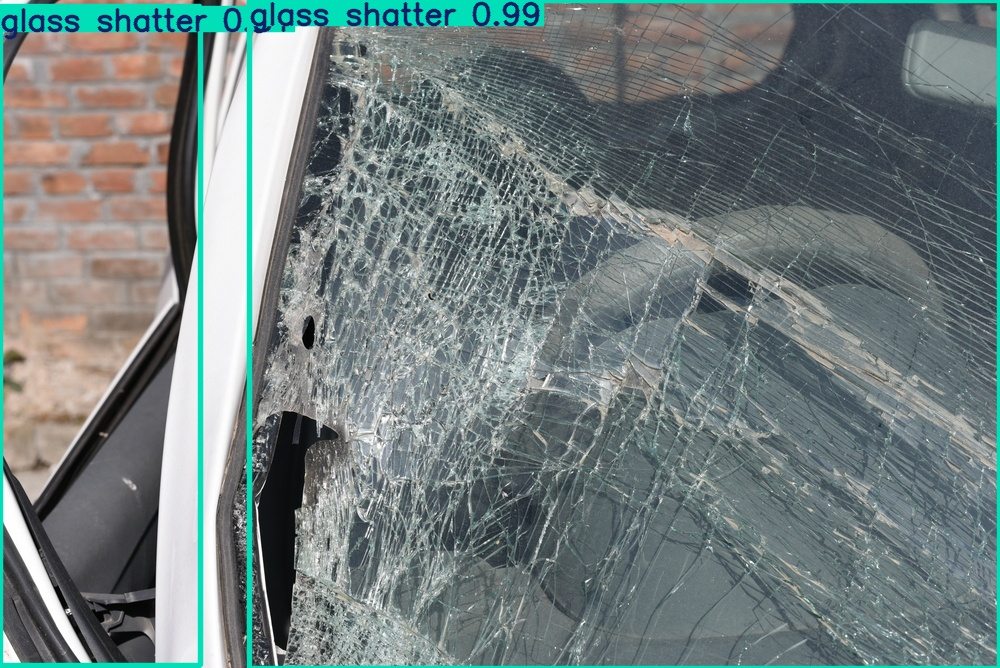

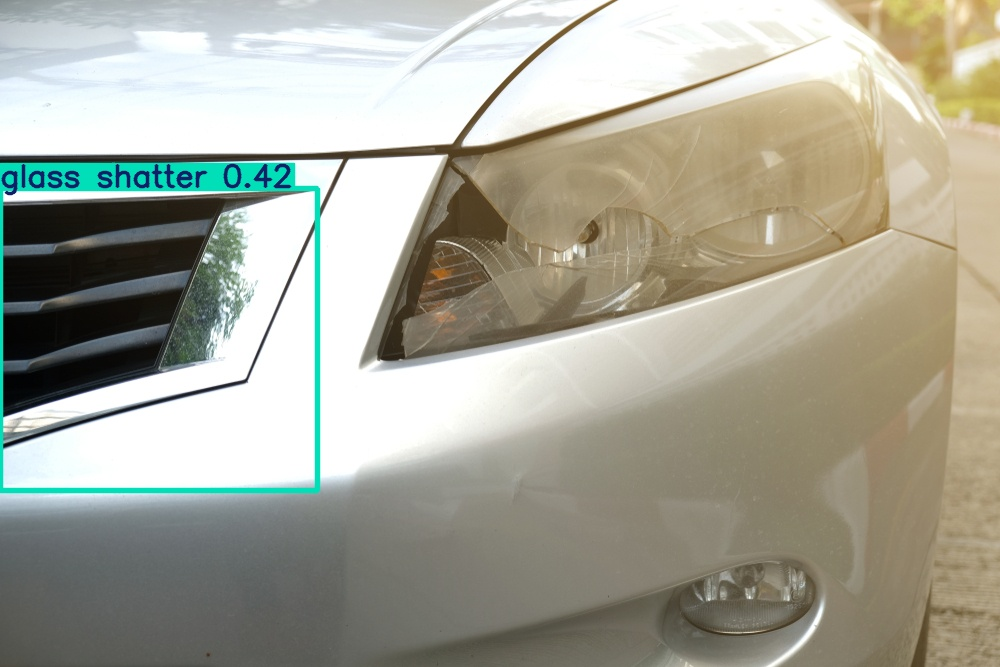

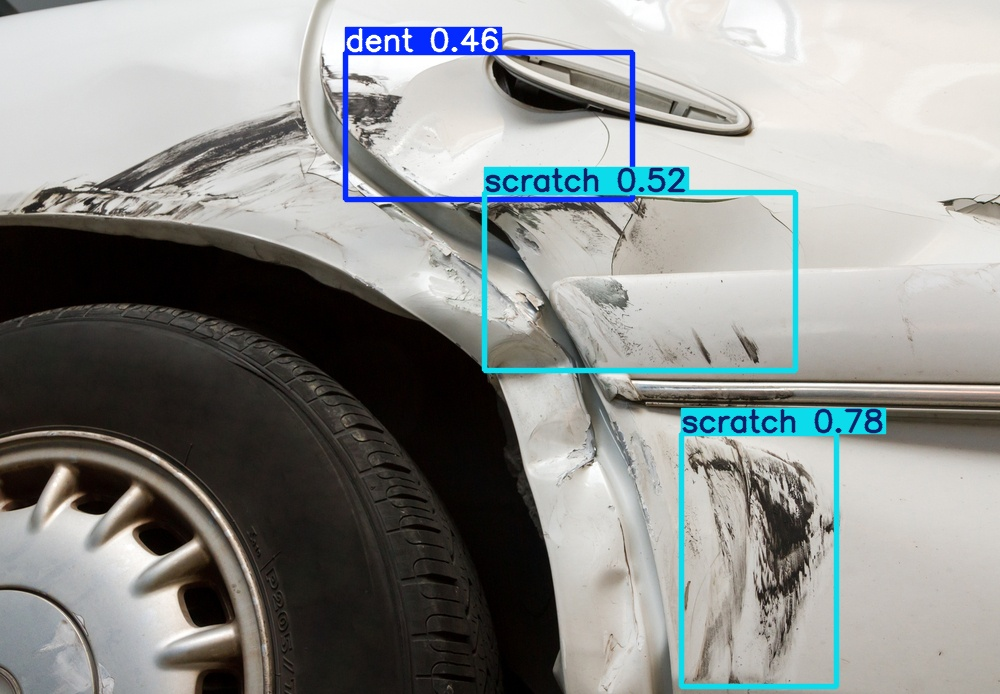

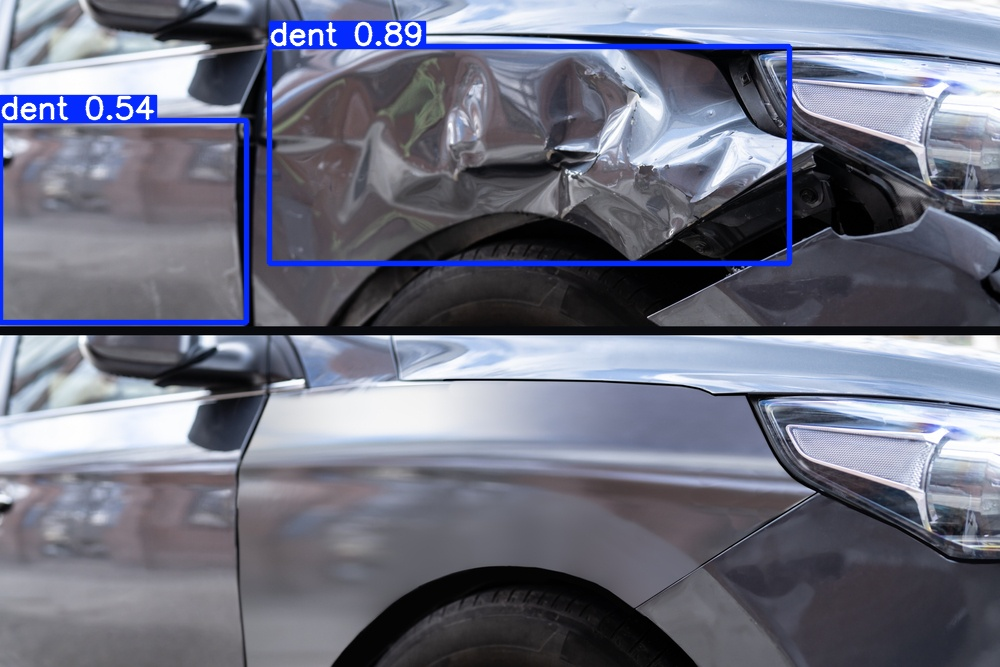

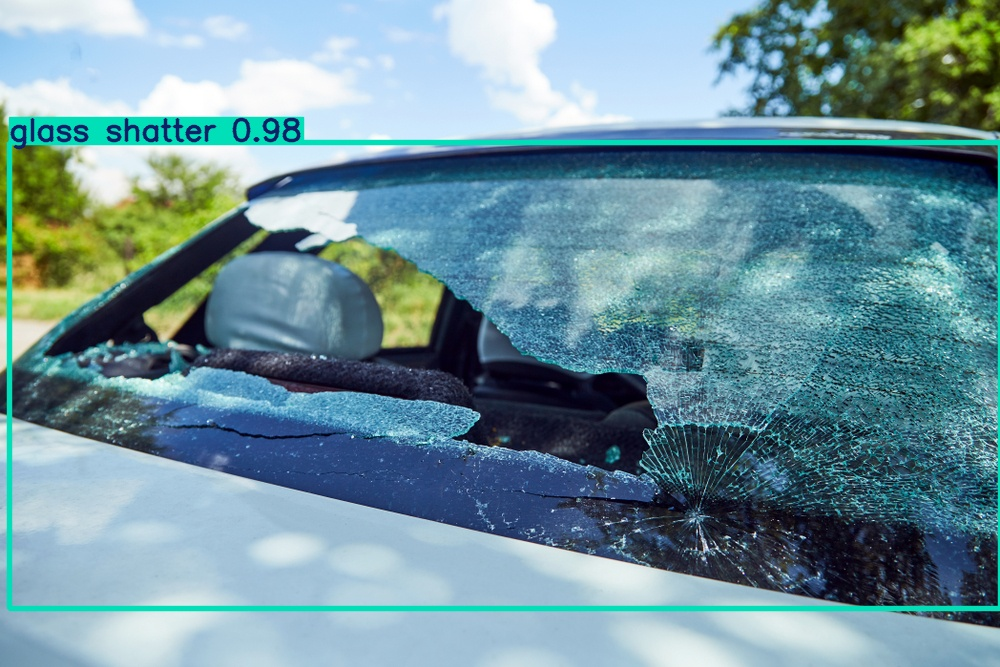

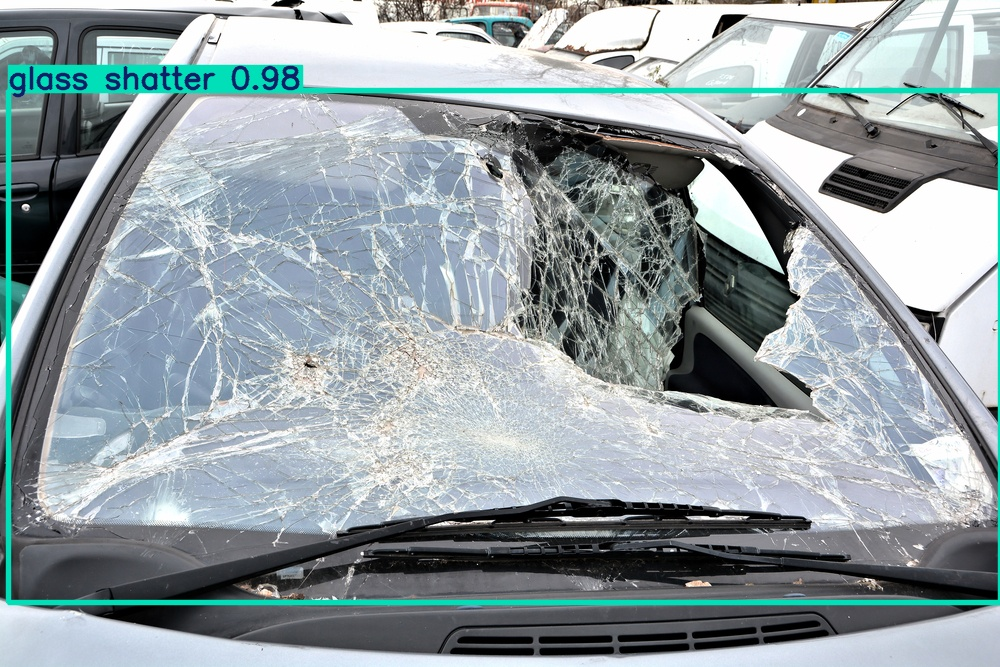

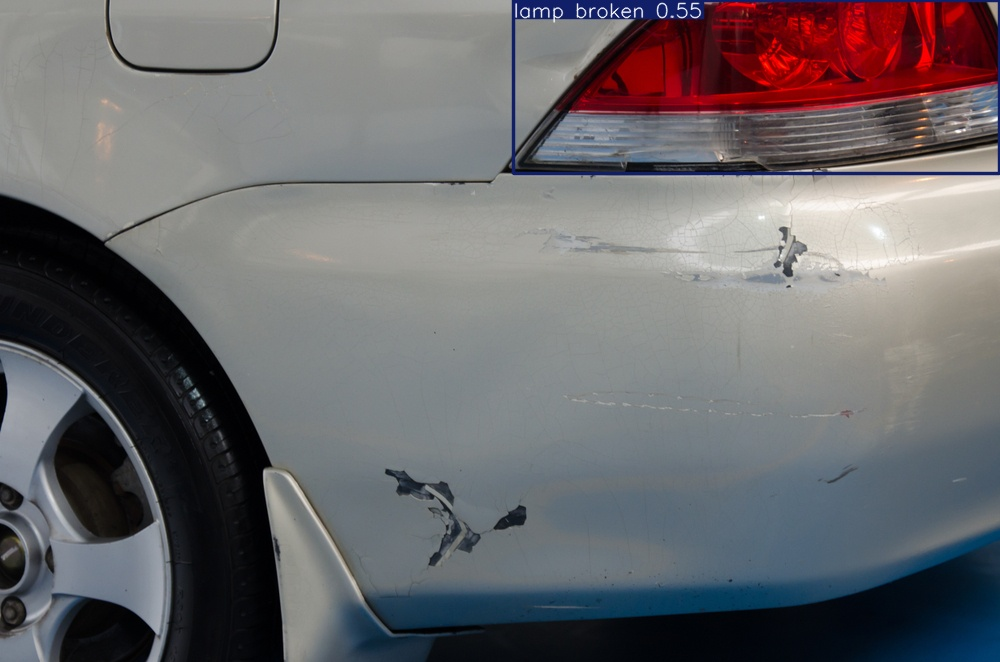

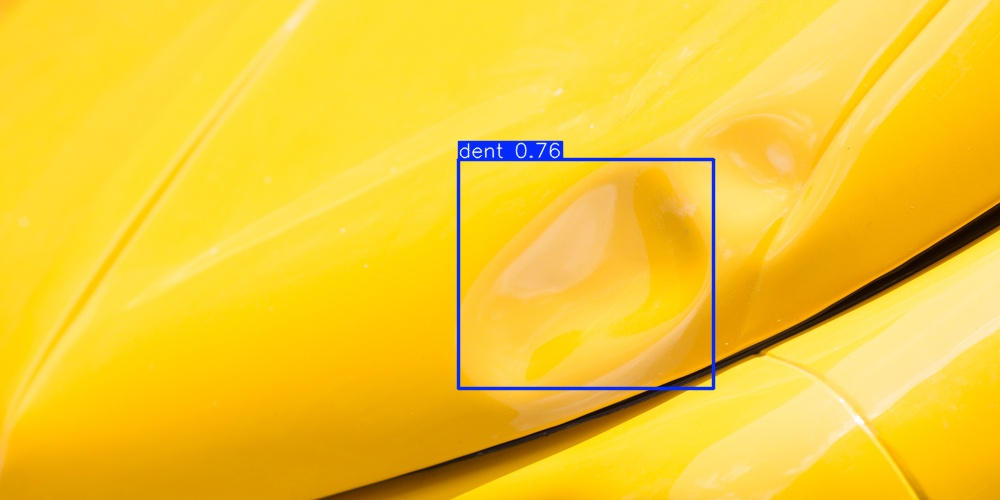

In [ ]:


from ultralytics import YOLO
import os
from IPython.display import Image, display


model = YOLO("/content/drive/MyDrive/CarDD1/runs/yolov8n_cardd/weights/best.pt")
test_dir = "/content/test_images"


image_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.png'))]
image_files = image_files[:8]

# Run inference
pred_dir = "/content/pred_8_images4"
results = model.predict(source=image_files, save=True, conf=0.4, project=pred_dir, name=".")

print("Predictions saved at:", pred_dir)

# Display predictions in Colab
predicted_images = [os.path.join(pred_dir, ".", os.path.basename(f)) for f in image_files]
for img_path in predicted_images:
    display(Image(filename=img_path))
